### IEORE 4571 Personalization Project 1###
# Recommender System #
****
#### Zihui Zhou, zz2694@columbia.edu, zz2694 , Han Wang, hw2761@columbia.edu,  hw2761 ####
#### Jing You, jy3035@columbia.edu, jy3035 ,Yi Ping Tseng, yt2690@columbia.edu,  yt2690 ####


### 1. Background and Objectives ###
$\qquad$ Developing personalized recommendations based on customers’ behavior data has played an important role in the digital media industry, for which companies may retain loyal customer relationships and attract new customers in the long run. In a specific case, film recommendations are given to customers based on their previous ratings and reviews. In our project, we try to build a system to serve users by recommending movies they may like. We explore this topic through analyzing “ml-20m” dataset from MovieLens, a web-based movie recommendation system. The dataset consists of 20,000,263 five-star ratings across 27,278 movies created by 138,493 users between January 09, 1995 and March 31, 2015. We mainly focus on using explicit ratings data to make predictions on users’ ratings for unwatched films. Based on these rating predictions, we try to avoid suggesting only the most popular films and  recommend films with higher predicted ratings to users. 

$\qquad$ During the analysis process, we’ve considered the following business rule: for the users who are new to the rating system and have a relatively small amount of ratings, the recommendation model will result in less accurate predictions and larger bias.

### 2. Data Analysis ###
$\qquad$ We would start approaching the problem by understanding our movielens-20m dataset. In this project, we are mainly using the ratings.csv. Each line of the csv file contains a rating of a movie from one user, where the ratings is rated on 1 to 5 scale and half score is allowed.

The number unique of users is 138493
The number of unique items is 26744
The sparsity level is 99.5 %


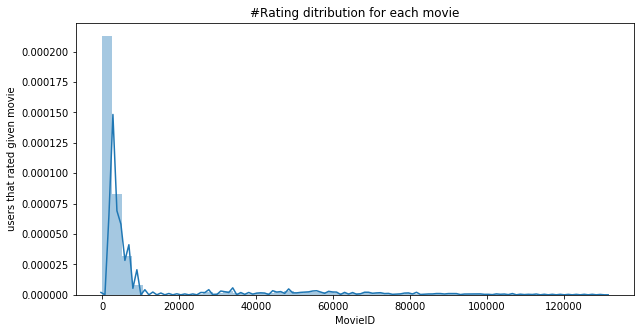

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
df = pd.read_csv('downloads/ml-20m/ratings.csv',sep = ',',usecols = ['userId','movieId','rating'])
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = round(1.0-len(df)/float(n_users*n_items),3)
print('The number unique of users is',n_users)
print('The number of unique items is',n_items)
print('The sparsity level is',sparsity*100,'%')

fig, ax = plt.subplots(figsize=(10,5))
fig = sns.distplot(df['movieId'])
ax.set_ylabel('users that rated given movie')
ax.set_xlabel('MovieID')
ax.set_title('#Rating ditribution for each movie')
plt.show()

$\qquad$ The number of unique users is 138493 and the number of unique items is 26744. We also note that the sparsity level is 99.5 %, which suggests that we have a highly sparse dataset. Then we plot the ratings for each movie and we can see some movies have been rated a lot while others don’t. It clearly raise concerns like those movies that have been rated a lot may be more likely to be recommended for all users.

### 3. Collaborative Filtering Algorithms ###
$\qquad$ intro

### 3.1 Item-based collaborative filtering algorithm ###
#### i. Data Preprocessing ####
$\qquad$ Taking business concerns into considerations, we filter the dataset by setting the following constraints on the dataset: we choose users who have rated over 3000 movies and popular movies which were rated over 15000 times. After filtering, 56 active users and 252 movies remain in the dataset.

#### ii. Build item-item similarity matrix ####
1. Build iterm-user matrix (index: item, column: user)
2. Replace missing values ‘NAN’ with 0
3. Calculate cosine similarity between two movies 
4. K-nearest neighbors algorithm: Find out the top N closest neighbors as peer set by using cosine similarity as distance

#### iii. Predict ratings of unrated films for selected users ####
$\qquad$ Predictions are calculated from the following equation: prediction rating equals the sum of item average rating and normalized weighted neighbors ratings using cosine similarity:  
$$ p_{i,a} = \overline{r}_{a} + \frac{\sum_{u\in k}^{} (r_{u,i} - \overline{r}_{u})\times w_{a,u} }{\sum_{u\in k}^{} w_{a,u}}$$

### 3.2 Model-based collaborative filtering algorithm ###
$\qquad$ Model-based collaborative filtering makes use of the matrix factorization algorithm to represent users preferences with vectors in lower dimensions. ALS model is one of those algorithms that decomposes user-item matrix into low rank user matrix and item matrix such that users and products are described by a small set of latent factors that can be used to predict missing entries. ALS is good at dealing with the sparsity of the data, which is suitable for our movielens dataset. 


In [ ]:
import os
import pyspark
from pyspark import SparkFiles
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import rand, col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

seed = 100
sc = SparkContext()
filePath = "downloads/ml-20m/ratings.csv"


# read dataset into spark RDD
sc.addFile(filePath)
sqlContext = SQLContext(sc)
df = sqlContext.read.csv(
    SparkFiles.get("ratings.csv"), 
    header=True, 
    inferSchema=True
)

sqlContext.registerDataFrameAsTable(df, "df")
df = sqlContext.sql('''
    SELECT 
        userId AS user, 
        movieId AS item,
        rating
    FROM df
''')


# adding uniform random numbers for train/validation/test set
df = df.withColumn('TrainTest', rand(seed=seed))
dftrain = df.where(col('TrainTest') < 0.75).drop(*["TrainTest"])
dftest = df.where(col('TrainTest') >= 0.75).drop(*["TrainTest"])

In [ ]:
rmse_list = []
mae_list = []

ranks = [20]
regs = [0.05]
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")
mae = RegressionEvaluator(metricName="mae", labelCol="rating")

for rank in ranks:
    for reg in regs:
        als = ALS(rank = rank,regParam = reg, nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
        
        paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [rank]) \
            .addGrid(als.regParam, [reg])\
            .build()

        tvs = TrainValidationSplit(
            estimator=als,
            evaluator=rmse,
            estimatorParamMaps=paramGrid,
            seed=seed,
            trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
            parallelism=6,
        )

        model = tvs.fit(dftrain)
        testPred = model.transform(dftest)
        error1 = rmse.evaluate(testPred)
        error2 = mae.evaluate(testPred)
        print('{} latent factors and regularization = {}: validation RMSE is {}，MAE is {}'.format(rank, reg, error1,error2))
        rmse_list.append(error1)
        mae_list.append(error2)

### 3. Model Evaluation Methods ###
#### i. Cross-validation setup####
$\qquad $ We use the train-validation-test setup to tune hyper parameters and evaluate the model performance. The ratio is 50% training, 25% validation, and 25% testing.  
#### ii.Accuracy on training and test data ####
$\qquad$ For the evaluation of accuracy, we use the simplest baseline model. We predict the mean rating over the entire data set and calculate models’ accuracy using RMSE as the primary metric and MAE as the secondary metric. Then we use our collaborative filtering algorithm models to make predictions and calculate error to compare with the baseline model. The error on the training set is relatively smaller.
#### iii.Coverage on training and test data ####
$\qquad$ We use user coverage to calculate coverage on training and test data. For every user, we try to create a top 10 recommendation list. We use baseline mean to define if a recommendation is good or not. If the absolute difference between the predicted rating and the true rating is smaller than the absolute difference between the mean and the true rating, we consider it a good recommendation. 

### 4. Model Performance ###
$\qquad$ We implement the root mean square error (RMSE) and mean absolute error (MAE) measurements in the memory-based model to evaluate its performance, while implementing RMSE in the model-based model. In order to achieve relatively better RMSE, we’ve performed grid search to tune the hyperparameters in each model.

### 4.1 Performance of Item-based collaborative filtering algorithm
$\qquad$ It is obvious that the size of the neighbourhood would affect the result of the prediction for the item-based model. In order to explore such effect, we vary the size of the neighbourhood as the following: 10, 20,30. Consequently, the resulting RMSE is 0.8196 , 0.6847, 0.6403. We observe that for out data, the increase number in the neighbourhood size leads to the increase in the model performance.

$\qquad$ After tuning the hyperparameters under each case, we conclude our models by choosing the best hyperparameters that minimize evaluation metrics. In the item-based memory-based model, the final RMSE is 0.7058404931062546 , and MAE is  0.6478214709289709. Comparing with the baseline RMSE: 1.0519832166584029 and baseline MAE: 0.840690943200106, it is lower by 33% and 23%.

### 4.2 Performance of Item-based collaborative filtering algorithm
$\qquad$ The number of latent dimensions used in the matrix factorization impacts our result of prediction. Increasing the number of latent dimensions would improve the predictions until the number is too high that the model tends to overfit. We vary the number of latent dimensions from the following: 5, 10, 20. In addition, since ALS uses L2 regularization, the regularization parameter used in the als model also impacts the prediction result. Increasing the regularization parameter would avoid overfitting but we also want to limit the parameter that it won’t cause a great increase in bias in the model. We vary the parameter of regularization from the following: 0.05, 0.01, 1. We tuned both parameters using a random sample size that is 0.1% of the complete data set. As we can see, under the same rank, the smaller the regularization the lower the error. 

$\qquad$ Under the model-based model-based model, the final RMSE is 0.7953830458336725,  and MAE is 0.6172952042333186. Comparing with the baseline RMSE and baseline MAE, it is lower by 25% and 26% 

### 4.2 Model size variation
$\qquad$ For different sample size, it is reasonable for models to have different performance. In order to understand how the evaluation metric change with the training set size, we modified the training set size as 1%, 10%,  30%, 50%  of the entire dataset size. According to our experiments, the overall accuracy changes over different training set sizes: the model with larger training set size has a higher accuracy (smaller RMSE) but requires a longer training time.

### 5. Concolusion
#### i. Result ####
$\qquad$ After tuning the hyperparameters under each case, we conclude our models by choosing the best hyperparameters that minimize evaluation metrics. In the item-based memory-based model, the final RMSE is 0.7058404931062546 , and MAE is  0.6478214709289709. Comparing with the baseline RMSE: 1.0519832166584029 and baseline MAE: 0.840690943200106, it is lower by 33% and 23%.  Under the model-based model-based model, the final RMSE is 0.7953830458336725,  and MAE is 0.6172952042333186. Comparing with the baseline RMSE and baseline MAE, it is lower by 25% and 26%  . Therefore, we meet our hypothetical objectives.
#### ii. Limitations ####
$\qquad$ However, there are some business concerns that need to be taken into consideration when making predictions and recommendations based on the MovieLens dataset. Some users have rated many more films and the ratings range over 10 years. Considering that users’ preferences change over time, more recent ratings would be more important for predictions compared with the previous ones. Therefore, bias may exist if the model gives each rating the same weight. For the current model we leave out the consideration on timestamp and give all the ratings the same weight. To improve the model furtherly, we can give a higher weight on user’s recent rating and a lower weight on user’s past ratings based on the timestamp of the ratings.
#### iii. Potential Improvement ####
$\qquad$ An improved model could be a model that also take timestamp as consideration. In order to take user preferences change into account, we can assign a larger weight on  users’ recent rating and a smaller weight on user’s past rating.